Remarks from the author who crawled the datasets
Reviews with Y/N: Reviews obtained from the restaurant page wherein we get all Y reviews from the filtered section and N reviews from the regular page.

Reviews with YR/NR: Reviews obtained from the reviewer profile page. These reviews are not just for restaurants but for every business the reviewer put a review for. We used it to identify how many of his reviews were filtered. The YR is determined by whether the review was availble on that particular business page. If it wasnt present (we determine this by crawling every page for that business exhaustively) we gave it YR as in we assumed it was filtered. If it was present it was given a NR value.

In the paper, "What Yelp Fake Review Filter might be Doing?" (ICWSM'13), the author only used reviews with label Y and N.

In [101]:
import matplotlib.pyplot as plt

import collections
import re, string
import sys
import pickle as pkl
import time
from nltk.corpus import stopwords
from tqdm import tqdm
import seaborn as sns
from subprocess import check_output
%matplotlib inline
from sklearn.model_selection import train_test_split
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp
from math import log

In [4]:
import sqlite3
from glob import glob; from os.path import expanduser
import pandas as pd
conn_hotel = sqlite3.connect(glob(expanduser('./data/yelpHotelData.db'))[0])
cursor = conn_hotel.cursor()


# Data Preprocessing

### In the below section we have merged the dataset of hotel with hotel_reviewer( the person who writes the reviews) and hote_review (which contains the information of review as a text)

In [5]:
# read the data set from Db format and get the hotel info
hotel = pd.read_sql('SELECT * FROM hotel' ,conn_hotel)
hotel.to_csv('./data/yelpHotelData.csv', index=False)
# read the data set from Db format and get the review info
hotel_review = pd.read_sql('SELECT * FROM review' ,conn_hotel)
hotel_review.to_csv('./data/hotel_review.csv', index=False)


In [6]:
# read the data set from Db format and get the reviewer info
hotel_reviewer = pd.read_sql('SELECT * FROM reviewer' ,conn_hotel)
hotel_reviewer.to_csv('./data/hotel_reviewer.csv', index=False)

In [7]:
#size of the review data
hotel_review.size

6883290

In [8]:
hotel_review=hotel_review.sort_values(by=['reviewerID', 'date'])

### clean the hotel_review data set



In [9]:
# Date - remove the unwanted str and newlines from the date
hotel_review['date'] = hotel_review['date'].str.replace('Update - ', '')

In [10]:
hotel_review['date'] = hotel_review['date'].str.replace('\n', '')

In [11]:
hotel_review['date'].sort_values(ascending=False)

179314    9/9/2012
328955    9/9/2012
92805     9/9/2012
486864    9/9/2012
75335     9/9/2012
            ...   
415329    1/1/2006
294012    1/1/2006
415317    1/1/2006
294010    1/1/2006
232890    1/1/2006
Name: date, Length: 688329, dtype: object

In [12]:
hotel_review.sort_values(by=['rating','date'],ascending=False)

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,hotelID
644222,9/9/2012,ik4b00QGP8IIzKsq_PiopQ,0G-QF457q_0Z_jKqh6xWiA,Pangaea: Latin for those shiny objects that cr...,5,6,7,4,NR,HnexCr8FP36qeBe_Wamlwg
252023,9/9/2012,ZYmVT7Htq4GtUifcYDwYOw,0tvCcnfJnSs55iB6mqPk3w,What is the best way to see a skyline that is ...,5,2,1,0,NR,V_sTEm_6xOkwBIb_cS8vCg
135153,9/9/2012,ybQKuI8apN1DZp4xHPQc5A,1eOJSCb2aDQakloIzVqiYg,Linda Ly of Norm Reeves Honda is great to do b...,5,0,0,0,NR,pU8oT0SJq_Y1r1uI8lj5qA
75335,9/9/2012,18OCntn9wxTwe8KHwdQ2BA,2p35UrsLuMspndW5lZjJgQ,So much beauty. First time in an old mission a...,5,2,2,1,NR,_aZCgLzfPmuLV0nPNxdeQw
278673,9/9/2012,keQVUGiZk1YYvBAfrg84pQ,2sluIPYMWfcxuNXZmRsOaA,This Narghile Lounge is by far one of the top ...,5,1,1,0,NR,Sfq5QVxf0imyjvXDIyLVMA
...,...,...,...,...,...,...,...,...,...,...
654346,1/1/2008,3LE9nzYXsGkzjHG42dacnA,2ALy0Qjcv_J285NGRT_nZg,This newspaper is a joke. And to the person th...,1,6,4,6,YR,AI9S24ooQjguUR5P9n_mKg
374615,1/1/2008,BEuQpmjGyuEKROP9dZx4ug,6xzTqv7bDL-hKm37_wwKwg,"What an obnoxious airport to get to. First, yo...",1,0,0,0,YR,RQ7T-DWCMcfsRxwytHUOTA
587403,1/1/2008,C3R37p-m85SQQv07DDPJPQ,apH-zpPZLpr6PTZ84vzklw,While it's a big plus that this Walgreens is o...,1,0,0,0,YR,c8h3VFeCV6436OmQjQ8__Q
451350,1/1/2008,Lo9DTPMlcTnT2W9W-k0vwg,p6nBKyT9Y_pFJ1WxVEowwA,This McDonald's really sucks. The chicken nugg...,1,0,0,0,NR,NQRJYSIGyYlm-YNfRJYgiQ


In [13]:
hotel_review.sort_values(by=['rating'])

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,hotelID
177127,6/25/2009,FEalCYuIR2IV3Qd3XQBmfw,wkrFqNxwTEEkG3mJV88Izw,"I love crepes, BUT I love soft crepes. Me no l...",1,13,6,5,YR,xg_OXQY_DOFuyV43N1KgiQ
5372,6/6/2012,oUMNIWwiZEb265z9U9NSUQ,K3jhJn6cy1-yRsxAvKu_vw,This place is a NASTY....I would not recommend...,1,0,0,0,Y,QnWFR5zQuLGL12EM_SZb8Q
103837,6/30/2008,Z19naoqNf4GovaJjvtFpmg,b9PYv393148RBlfX_b62Sw,I am ashamed to admit I have finally been here...,1,2,0,0,YR,JwJa6nY_wlZEjagVleWQ-Q
272973,1/6/2012,8b9OrbpbL55Fta1ig0013A,OwUchEzH_wbPPhWNtiZyLQ,my very first one star review. not a good plac...,1,1,0,0,NR,P5Af0--HXEboLkxPjDMo-w
491546,5/5/2009,3A67sXXZ07U_eKRkKGniGg,UlrVrgJTLH4gk6MPNbX1eQ,Ew! My hubs and I have passed by there often ...,1,1,2,2,NR,MZGu2nxkeAIBhie479i1mw
...,...,...,...,...,...,...,...,...,...,...
495630,8/15/2011,YUn8Hv7SsaLdVvSCWllViw,IU86PZPgTDCFwJEuAg2j7g,Wowsers I'd eat one of these tamales off of th...,5,6,5,5,NR,jZWalKRIGMVwm3gNI0idrA
650076,1/19/2010,nuDeIJemr7pBWFeh9zM0Sw,jEyb7v42sgIZZhwxnynFfg,After a nasty stay at the 4 Queens I moved to ...,5,0,0,1,YR,if59L5DHM4pPMrCx9HuD8A
650118,10/16/2009,7rStrfM7C0uKSZKVddUK9Q,jEyb7v42sgIZZhwxnynFfg,This place makes awesome beach type rum and a ...,5,0,1,1,NR,VL8K7R-rlGbvsGKS8zfouA
649527,3/24/2012,Ga6n7FEGzpjW9SGiDleT9w,jCGuGQuSsVUrt4vbQpfi7g,I hope you guys will be opening back up again ...,5,1,0,0,NR,qS065zOsJA0OFsxWRrb0Qw


In [14]:
hotel_review.head(10)

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,hotelID
49056,10/20/2011,A9sldQP1-cn9AbcSPKPGGw,-0avJ-EVYjNCVwh0r_irUQ,"Unfortunately, Pension Values let both my ex-w...",2,0,0,0,NR,tl7wHYU9z4U8u4DlWH36Jw
5179,6/18/2011,P1dYKC-Mfphz9T24sWm4ww,-0avJ-EVYjNCVwh0r_irUQ,where do I start. The GM was a nice guy for ha...,1,0,0,0,Y,ubNzerxb8ox5bmA2EGkKBg
49058,6/18/2011,XExTH25XjsjmASfOx0J5MA,-0avJ-EVYjNCVwh0r_irUQ,The course was in great shape. The holes and v...,5,0,0,0,NR,qcltTph9ALOpiljbwMluKQ
49060,6/18/2011,hV9K2rWfanrWEK8WZ2cBtA,-0avJ-EVYjNCVwh0r_irUQ,"MEH....So so, Way overpriced for what you get....",2,0,0,0,NR,gtqtnzgzDCWVFi298dIvow
49064,6/18/2011,45Ws0c5_dQs46B4Oacf_Nw,-0avJ-EVYjNCVwh0r_irUQ,Good time if you are not an experienced driver...,2,2,0,0,YR,fOh0yRN8xOoiC0KebvSJ2Q
324013,10/16/2012,dc8jNBIiexHLegiA2SJz5A,-2N-pSWoeBa6L06_5QLrQQ,BangBang lauches itself as a strong competitor...,4,0,0,0,NR,Ww6NDwDzQ90mfA7iLheQ8w
207673,10/9/2012,e46WXiT1GikwMNhI05zfKQ,-2N-pSWoeBa6L06_5QLrQQ,My favorite place in Ames! I've been going her...,5,0,0,0,NR,nBD8--K7WqV_j7jGR7_Z5w
207674,10/9/2012,Wn0VwW3SswHAYD5DXiqmxQ,-2N-pSWoeBa6L06_5QLrQQ,One of my favorite bars in Des Moines that see...,4,0,0,0,NR,Ndlvnjs68sRYEg6Vkt1bnQ
207677,10/9/2012,4kT5wUSQiiGteHbmRjkMJQ,-2N-pSWoeBa6L06_5QLrQQ,"Nice setting, tapas, and drinks! When I go to ...",4,0,0,0,NR,5_9l4Br1KC148hT0B3-J9A
207679,10/9/2012,OexHMK6E2EEC3s9jdkdkTQ,-2N-pSWoeBa6L06_5QLrQQ,Excellent Tapas and drinks I went Tapa and Bar...,4,1,1,1,NR,pLnB-BglN_bphYUL2kvAgw


# hotel reviewer 

#### Here hotel reviewer indicated the person who writes comment to the hotel

In [15]:
hotel_reviewer['yelpJoinDate']

0             May 2011
1         January 2010
2          August 2008
3       September 2009
4          August 2008
             ...      
5118        April 2011
5119        April 2009
5120     February 2010
5121         June 2010
5122        March 2012
Name: yelpJoinDate, Length: 5123, dtype: object

In [16]:
#### we convert the month name into the number with the below function 
def month_string_to_number(string):
    m = {
        'january': 1,
        'february': 2,
        'march': 3,
        'april':4,
         'may':5,
         'june':6,
         'july':7,
         'august':8,
         'september':9,
         'october':10,
         'november':11,
         'december':12
        }
    s = string.strip().lower()

    try:
        out = m[s]
        return out
    except:
        raise ValueError('Not a month')

In [17]:
# we convert the yelp join date of reviewer who write comment to the hotel data set
hotel_reviewer['yelpJoinDate'] =hotel_reviewer['yelpJoinDate'].apply(lambda x: str(month_string_to_number(x[:-5])).strip()+str('/1/')+x[-4:])

In [18]:
hotel_reviewer['yelpJoinDate']

0       5/1/2011
1       1/1/2010
2       8/1/2008
3       9/1/2009
4       8/1/2008
          ...   
5118    4/1/2011
5119    4/1/2009
5120    2/1/2010
5121    6/1/2010
5122    3/1/2012
Name: yelpJoinDate, Length: 5123, dtype: object

In [19]:
# create a data as dataframe which has the merged information of hotel_review and hote_reviewer
data=pd.merge(hotel_review,hotel_reviewer[['reviewerID','name','location','yelpJoinDate']],on='reviewerID',how='outer')

In [20]:
print('data.size:',data.shape)
print('review.size:',hotel_review.shape)

data.size: (688329, 13)
review.size: (688329, 10)


In [21]:
data = data.rename(columns={'name': 'reviewer_name','location':'reviewer_location'})

In [22]:
data.head()

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,hotelID,reviewer_name,reviewer_location,yelpJoinDate
0,10/20/2011,A9sldQP1-cn9AbcSPKPGGw,-0avJ-EVYjNCVwh0r_irUQ,"Unfortunately, Pension Values let both my ex-w...",2,0,0,0,NR,tl7wHYU9z4U8u4DlWH36Jw,Pasha Mke F.,"Redondo Beach, CA",6/1/2011
1,6/18/2011,P1dYKC-Mfphz9T24sWm4ww,-0avJ-EVYjNCVwh0r_irUQ,where do I start. The GM was a nice guy for ha...,1,0,0,0,Y,ubNzerxb8ox5bmA2EGkKBg,Pasha Mke F.,"Redondo Beach, CA",6/1/2011
2,6/18/2011,XExTH25XjsjmASfOx0J5MA,-0avJ-EVYjNCVwh0r_irUQ,The course was in great shape. The holes and v...,5,0,0,0,NR,qcltTph9ALOpiljbwMluKQ,Pasha Mke F.,"Redondo Beach, CA",6/1/2011
3,6/18/2011,hV9K2rWfanrWEK8WZ2cBtA,-0avJ-EVYjNCVwh0r_irUQ,"MEH....So so, Way overpriced for what you get....",2,0,0,0,NR,gtqtnzgzDCWVFi298dIvow,Pasha Mke F.,"Redondo Beach, CA",6/1/2011
4,6/18/2011,45Ws0c5_dQs46B4Oacf_Nw,-0avJ-EVYjNCVwh0r_irUQ,Good time if you are not an experienced driver...,2,2,0,0,YR,fOh0yRN8xOoiC0KebvSJ2Q,Pasha Mke F.,"Redondo Beach, CA",6/1/2011


In [23]:
hotel.shape

(283086, 13)

In [24]:
hotel.head()

,hotelID,name,location,reviewCount,rating,categories,address,AcceptsCreditCards,PriceRange,WiFi,webSite,phoneNumber,filReviewCount
0,pSLh_XyV_3QS1hNsBOGHiQ,Old Chicago Inn,"Old Chicago Inn - Lakeview - Chicago, IL",1,3.0,"Event Planning & Services, Hotels, Hotels & Tr...",3222 N Sheffield Ave (between Belmont Ave & Sc...,Yes,$$,Free,http://www.oldchicagoinn.com,(773) 245-0423,5
1,tQfLGoolUMu2J0igcWcoZg,Tokyo Hotel,"Tokyo Hotel - Near North Side - Chicago, IL",6,3.0,"Event Planning & Services, Hotels, Hotels & Tr...","19 E Ohio St Chicago, IL 60611 Neighborhood: N...",No,$,No,http://tokyohotels.webs.com/,(312) 787-4900,5
2,33Xc1Bk_gkSY5xb2doQ7Ng,The Tremont Chicago Hotel at Magnificent Mile,The Tremont Chicago Hotel at Magnificent Mile ...,44,3.0,"Event Planning & Services, Hotels, Hotels & Tr...",100 East Chestnut (between Ernst Ct & Michigan...,Yes,$$,Free,http://www.tremontchicago.com,(312) 751-1900,5
3,2nnXespKBBNtDQTtrumNFg,Inn At Lincoln Park,"Inn At Lincoln Park - Lincoln Park - Chicago, IL",20,2.0,"Event Planning & Services, Hotels, Hotels & Tr...",601 W Diversey Pkwy (between Broadway St & Cam...,Yes,$$$,Free,None,(773) 348-2810,5
4,SNuJYJewLhunxlhEezo15w,Carleton Hotel,"Carleton Hotel - Oak Park, IL",31,4.0,"Event Planning & Services, Hotels, Hotels & Tr...",1110 Pleasant St (between Maple Ave & Marion S...,Yes,$$,Free,http://www.carletonhotel.com/,(708) 848-5000,5


In [25]:
# data['location']
# data['location'] = print(data['location'].apply(lambda x: ''.join(str(x).split('-')[-1:])))
hotel['location'] = hotel['location'].apply(lambda x: ''.join(str(x).split('-')[-1:]))
hotel['location']

0                Chicago, IL
1                Chicago, IL
2                Chicago, IL
3                Chicago, IL
4               Oak Park, IL
                 ...        
283081           Roma, Lazio
283082           Roma, Lazio
283083           Roma, Lazio
283084     San Francisco, CA
283085           Seattle, WA
Name: location, Length: 283086, dtype: object

In [26]:
# merge the information of the hotel into the data
data=pd.merge(data,hotel[['hotelID','location','reviewCount','filReviewCount','PriceRange']],on='hotelID',how='outer')

In [27]:
data.head(10)

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,hotelID,reviewer_name,reviewer_location,yelpJoinDate,location,reviewCount,filReviewCount,PriceRange
0,10/20/2011,A9sldQP1-cn9AbcSPKPGGw,-0avJ-EVYjNCVwh0r_irUQ,"Unfortunately, Pension Values let both my ex-w...",2.0,0.0,0.0,0.0,NR,tl7wHYU9z4U8u4DlWH36Jw,Pasha Mke F.,"Redondo Beach, CA",6/1/2011,"Santa Maria, CA",1.0,0.0,None
1,6/18/2011,P1dYKC-Mfphz9T24sWm4ww,-0avJ-EVYjNCVwh0r_irUQ,where do I start. The GM was a nice guy for ha...,1.0,0.0,0.0,0.0,Y,ubNzerxb8ox5bmA2EGkKBg,Pasha Mke F.,"Redondo Beach, CA",6/1/2011,"Chicago, IL",165.0,13.0,$$$
2,7/26/2010,fdPuQ9hUVAlZHS9uFU804A,-3s52C4zL_DHRK0ULG6qtg,Loved this place! Went for a couple nights wit...,4.0,0.0,0.0,0.0,N,ubNzerxb8ox5bmA2EGkKBg,Sara Mrs. Andrew W B.,"Wheaton, IL",5/1/2010,"Chicago, IL",165.0,13.0,$$$
3,5/26/2009,dPITmLXb682RcXoSgeduTA,-7KsknNh6tpHJPjs52sYsA,I just had my wedding at Hotel Allegro and it ...,5.0,0.0,2.0,0.0,N,ubNzerxb8ox5bmA2EGkKBg,Mara I eat out too much... S.,"Chicago, IL",5/1/2006,"Chicago, IL",165.0,13.0,$$$
4,1/23/2010,3V3Yoa861y2hfX4ALra7XQ,-Vy8Q4uAt-X7KzlTjnxmXQ,Having our wedding at the Hotel Allegro was ha...,5.0,4.0,3.0,0.0,N,ubNzerxb8ox5bmA2EGkKBg,Amanda W.,"Chicago, IL",5/1/2008,"Chicago, IL",165.0,13.0,$$$
5,3/5/2008,rw2zUUiThq96lgBwwqXXug,-kSugCrd4mavS0tpiG6L-g,"After the remodel of the room, it is great, ni...",5.0,0.0,0.0,0.0,Y,ubNzerxb8ox5bmA2EGkKBg,marie S.,"Chicago, IL",3/1/2008,"Chicago, IL",165.0,13.0,$$$
6,11/2/2008,vrkfV8wZaqpnd-WdyzHJKw,-xXMng-AgRWe80kqg8zzfw,There's a certain ridiculousness about this pl...,3.0,2.0,1.0,0.0,N,ubNzerxb8ox5bmA2EGkKBg,Urwhatuea T.,"Austin, TX",6/1/2007,"Chicago, IL",165.0,13.0,$$$
7,6/22/2008,56tUz-g0TTLrhKZlGXMwnQ,0Chi_CzoTmkw1NvZg0sksg,The newly remodeled Allegro is dead sexy. The...,4.0,4.0,3.0,1.0,N,ubNzerxb8ox5bmA2EGkKBg,Jennifer Under Review B.,"Oakland, CA",3/1/2008,"Chicago, IL",165.0,13.0,$$$
8,3/24/2009,LaP-9BZJDoTMC21Wv81S5g,0G43iKmKRMdGWcmvfSH7sw,Stayed here Valentines Night and was very plea...,4.0,1.0,2.0,1.0,N,ubNzerxb8ox5bmA2EGkKBg,Donna just call me the Deejer R.,"Schaumburg, IL",3/1/2009,"Chicago, IL",165.0,13.0,$$$
9,7/12/2011,tEVngiL6EwLz6uuQxicV5w,0TWqlGuQYMwgpiNCi5we2w,I came for a training and stayed 2 nights. The...,3.0,0.0,0.0,0.0,N,ubNzerxb8ox5bmA2EGkKBg,Sammy Complaining is an artform T.,"Columbus, OH",10/1/2010,"Chicago, IL",165.0,13.0,$$$


In [28]:
data=data.rename(columns={'date':'review_created_date'})
data=data.sort_values(by=['hotelID', 'review_created_date'])

### The below data have the merged information from hotelreview, reviewer , hotel

In [29]:
data.head()

,review_created_date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,hotelID,reviewer_name,reviewer_location,yelpJoinDate,location,reviewCount,filReviewCount,PriceRange
507870,10/13/2012,4otsBJUpVaA0K7-_hqD63g,Mt31ShDTsvPfjKoTsFJmbQ,"Only about 2 miles from the airport, this hote...",4.0,0.0,0.0,0.0,NR,--0Rizt5ryqiOqxgtyJk3Q,Tommy M.,"Vienna, VA",12/1/2008,Barcelona,2.0,0.0,€€
291918,11/27/2008,TWl6ERAXAw1r8kOElkcS4g,50wPDE_Gk936RYV7i4FJhw,I used to eat here in High School. It involve...,3.0,1.0,1.0,1.0,NR,--0kuuLmuYBe3Rmu0Iycww,"Haroun Oh my goodness, oh my damn K.","Detroit, MI",10/1/2006,"Berkley, MI",15.0,0.0,$
291920,3/13/2011,uHNzmJIOWYeG_YttnLSZmQ,L2JUm1kc8M3ji-Ud2HUBSw,"I came here often in high school, and have vis...",1.0,2.0,1.0,1.0,NR,--0kuuLmuYBe3Rmu0Iycww,Alexandra Newser and Schmoozer K.,"Astoria, NY",7/1/2007,"Berkley, MI",15.0,0.0,$
291919,6/8/2009,98UDSnXMrolNnF0Rb1PaTw,8YZimf72JDoW811K-DNyAg,I think it's the California Veggie sandwich th...,4.0,1.0,1.0,0.0,NR,--0kuuLmuYBe3Rmu0Iycww,Toni Rum Ham C.,"Ferndale, MI",3/1/2009,"Berkley, MI",15.0,0.0,$
81763,3/2/2010,axn3cVtDM8cf-r_BetH7EA,-xXMng-AgRWe80kqg8zzfw,I love you. Banh mi!!!!!!!!! Holy holy holy p...,5.0,4.0,2.0,2.0,YR,--164t1nclzzmca7eDiJMw,Urwhatuea T.,"Austin, TX",6/1/2007,"Austin, TX",124.0,0.0,$


In [30]:
reviews=pd.Series(data['reviewContent'])
review_length=[]
for review in tqdm(reviews):
    string=str(review).replace('\xa0','')
    string_list=string.split(" ")
    nb_words=len(string_list)
    review_length.append(nb_words)

100%|██████████| 688349/688349 [00:07<00:00, 87962.07it/s]


In [31]:
data['review_length']=review_length
data["review_length"] = pd.to_numeric(data["review_length"])

In [34]:
data.sort_values(by=['flagged'])

,review_created_date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,hotelID,reviewer_name,reviewer_location,yelpJoinDate,location,reviewCount,filReviewCount,PriceRange,review_length
248627,11/16/2010,vf78HlnP02sEbAGEXFIWHw,Rr5OAotIzOSJP0bAb6RDrg,I stayed at this place (Nov. 10-13) and I init...,3.0,2.0,0.0,0.0,N,BISUDalmPulSzHvsO3PhDA,Alex M.,"Los Angeles, CA",2/1/2010,"Chicago, IL",16.0,4.0,$$,297
191426,2/27/2012,ehMZt2RyLzcr-i3hjEhr7w,aZmkHjoEHe2MRl2W_xAMfQ,"As a frequent visitor to the the big city, I h...",2.0,0.0,0.0,0.0,N,sGhw4H2gzW0psZom0QuZMw,Jen B.,"Peoria, IL",6/1/2011,"Chicago, IL",92.0,11.0,$$$,430
191478,2/26/2012,F0g-r42NKIW8zdybs83lMA,xxsKHU4JPdWAZdAVL5v-ew,Nice jumping-off spot to go shopping on the ma...,4.0,0.0,0.0,0.0,N,sGhw4H2gzW0psZom0QuZMw,T D.,"Arlington Heights, IL",8/1/2011,"Chicago, IL",92.0,11.0,$$$,78
191455,2/22/2011,muCRtRodcRR1X9U3,oZZlu8ehrL5755ZA_clhFw,We attended a great party at the Knickerbocker...,4.0,0.0,0.0,0.0,N,sGhw4H2gzW0psZom0QuZMw,Charles A.,"Chicago, IL",1/1/2011,"Chicago, IL",92.0,11.0,$$$,30
191366,2/2/2010,ewe7mPdcZqN0c76cmw8L1A,AADT758x5G2bhwFBRDqLfA,Hotel Lobby Bar Project Review #8 - Martini Ba...,3.0,2.0,2.0,3.0,N,sGhw4H2gzW0psZom0QuZMw,Katie Slattern H.,"Chicago, IL",1/1/2007,"Chicago, IL",92.0,11.0,$$$,194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,heUeHr_CrPUXEldYSS7IWw,NaN,NaN,NaN,"Chicago, IL",1.0,0.0,None,1
688331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,k5_sOPZQRWSj3ceYVTAUQg,NaN,NaN,NaN,"Chicago, IL",2.0,0.0,None,1
688333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,kHQsDzksh3PcDkTz9MOjOg,NaN,NaN,NaN,"Chicago, IL",1.0,0.0,None,1
688337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lmYrOxPbPhAa-cYz3uaFFA,NaN,NaN,NaN,"Cambridge, MA",11.0,0.0,None,1


### To plot the data graph to represent the number of review having the flag fake and true

In [35]:
type_rev_len=data[['flagged','reviewID']].groupby('flagged').count()
type_rev_len.reset_index(inplace=True)
type_rev_len

,flagged,reviewID
0,N,5078
1,NR,415707
2,Y,780
3,YR,266764


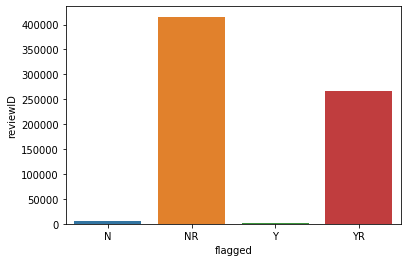

In [36]:
sns.barplot(x='flagged', y='reviewID', data=type_rev_len);

In [43]:
# hotel_reviewer.where(reviewerID='P5bUL3Engv-2z6kKohB6qQ')

print(hotel_review.loc[hotel_review['reviewerID'] == 'P5bUL3Engv-2z6kKohB6qQ'].groupby('flagged').size())
# sort_values(by=['NumberOfCounts'],ascending=False)
print(hotel_review.loc[hotel_review['reviewerID'] == 'EiwxlbR8fb68lMgEXhcWKA'].groupby('flagged').size())

print(hotel_review.loc[hotel_review['reviewerID'] == 'hQYc90YPvI5WAhxUF4Bo5Q'].groupby('flagged').size())

flagged
N        1
NR    3588
YR    1852
dtype: int64
flagged
N        5
NR    1142
YR     884
dtype: int64
flagged
N       1
NR    693
YR    664
dtype: int64


# In the below part we process the Graph convolution network using the review

### Data feature processing

#### In the below section we clean the words , remove the stop words, create a dictionary of clean words keeping their words count and the document where they occured, which moving forward we can use in our GCN model

In [44]:
# the function to calculate the amount of word in the reviews
def get_amount_of_words(text):
    if text is np.nan: return 0
    return len(re.split(r' ', text))

In [45]:
hotel_review['reviewLength']=hotel_review['reviewContent'].apply(get_amount_of_words)

In [47]:
# here we sort group our data set based on the review length only for the True review and take the first 10000
TrueHotelReview = hotel_review.sort_values(by =['reviewLength'],ascending=False).loc[hotel_review['flagged'].isin(['Y','YR'])][:10000]

In [48]:
# here we split our True Hotel review data set into train and test
true_train, true_test = train_test_split(TrueHotelReview, test_size=0.2)

In [49]:
# here we sort group our data set based on the review length only for the False review and take the first 10000
FalseHotelReview = hotel_review.sort_values(by =['reviewLength'],ascending=False).loc[hotel_review['flagged'].isin(['N','NR'])][:10000]

In [50]:
# here we split our false Hotel review data set into train and test
false_train, false_test = train_test_split(FalseHotelReview, test_size=0.2)

In [51]:
# we create a train hotel review by merging the data set create above using True_train and false_train
trainHotelReview = pd.concat([true_train, false_train])
# we create a test hotel review by merging the data set create above using True_train and false_train
testHotelReview = pd.concat([true_test, false_test])

In [52]:
trainHotelReview['DataType']='train'

In [53]:
testHotelReview['DataType']='test'

In [54]:
# we concatenate the train and test hotel review and create a finalhotel review dataset
FinalHotelReview = pd.concat([trainHotelReview, testHotelReview])

In [55]:
#reset the index of the dataframe
FinalHotelReview = FinalHotelReview.reset_index()

In [56]:
# to save all the text of review into the text file yelp_reviewAll
docs = []
for i in range(FinalHotelReview['reviewContent'].size):
    doc_content = FinalHotelReview['reviewContent'].iloc[i].replace('\n', ' ')
    docs.append(doc_content)

corpus_str = '\n'.join(docs)
f = open('./data/' + 'yelp'+'_reviewAll' + '.txt', 'w')
f.write(corpus_str)
f.close()

In [57]:
# to save train text vlaue in the  review into the text file as yelp_trianreviewAll
docs = []
for i in range(trainHotelReview['reviewContent'].size):
    doc_content = trainHotelReview['reviewContent'].iloc[i].replace('\n', ' ')
    docs.append(doc_content)

corpus_str = '\n'.join(docs)
f = open('./data' +'yelp'+'_trainreviewAll' + '.txt', 'w')
f.write(corpus_str)
f.close()

In [58]:
# to save test text vlaue in the  review into the text file as yelp_trianreviewAll
docs = []
for i in range(testHotelReview['reviewContent'].size):
    doc_content = testHotelReview['reviewContent'].iloc[i].replace('\n', ' ')
    docs.append(doc_content)

corpus_str = '\n'.join(docs)
f = open('./data' +'yelp'+ '_testreviewAll' + '.txt', 'w')
f.write(corpus_str)
f.close()

# remove words

In [59]:
from nltk.corpus import stopwords
import nltk
from nltk.wsd import lesk
from nltk.corpus import wordnet as wn

In [60]:
# function to clean the dataset
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [61]:
# download the stop words from the nltk to remove them
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

{'their', 'over', 'am', 'does', 'each', 'them', 'being', 'against', 'what', 'm', 'of', 'isn', 'hadn', "mustn't", 'ours', 'itself', 'ourselves', 'below', 'and', 'other', 'that', 'on', "needn't", 'his', "you'd", 'aren', 'both', 'my', 'just', "she's", "should've", 'up', 'himself', 'than', "weren't", 'this', 'while', 'don', 'she', "hadn't", 'doing', 'who', 'why', 'yours', "wasn't", 'ain', 'then', 'those', 'here', 'during', "you've", 'some', 'do', 'was', 'down', 'no', 'theirs', 'for', 'through', 'own', 'because', 'been', 'an', 'myself', "shan't", 'shouldn', "wouldn't", 'our', 'if', 'there', 'which', 'its', "don't", 'didn', 'were', 're', 'most', 'until', 'into', 'd', 'same', 'you', 'any', "doesn't", 'her', "mightn't", 'should', 'your', 'will', 'before', 'the', 'such', "haven't", 'weren', 'we', "won't", 'has', "you'll", 'won', 'mightn', 'so', "isn't", 'y', 'after', 'a', 'again', 'by', "didn't", 'or', 'hers', 'not', 'couldn', 'nor', 'having', 'about', 's', 'only', 'they', 'he', 'shan', 'above'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/drcaptainray/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
#load all the review from the text file
doc_content_list = []
f = open('./data/yelp_reviewAll.txt', 'rb')
for line in f.readlines():
    doc_content_list.append(line.strip().decode('latin1'))
f.close()


In [63]:
# we clean the text by removing unnecessary character in the text 
# we create a dictionary to keep the frequency of words
# to remove rare words
word_freq = {}  

for doc_content in doc_content_list:
    temp = clean_str(doc_content)
    words = temp.split()
    for word in words:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

In [64]:
# we split the each review after which we remove the words from the stop word and also remove the words who frequency is more than 5
clean_docs = []
for doc_content in doc_content_list:
    temp = clean_str(doc_content)
    words = temp.split()
    doc_words = []
    for word in words:
        # word not in stop_words and word_freq[word] >= 5
        if word not in stop_words and word_freq[word] >= 5:
            doc_words.append(word)

    doc_str = ' '.join(doc_words).strip()
    #if doc_str == '':
        #doc_str = temp
    clean_docs.append(doc_str)
# keep the clean data from the clean_docs as a str seprated by newline in the clean corpus variable
clean_corpus_str = '\n'.join(clean_docs)


In [65]:
# store the value of clean data into the clean reviewall text
f = open('./data/yelp_CleanreviewAll.txt', 'w')
#f = open('data/wiki_long_abstracts_en_text.clean.txt', 'w')
f.write(clean_corpus_str)
f.close()

In [66]:
#store the meta data as a label on the yelp_metareviewAll

doc_name_list = []
for i in range(FinalHotelReview['reviewContent'].shape[0]):
    temp = FinalHotelReview.iloc[i]
    if temp['flagged'] in ['YR','Y']:
        string = str(i) + '\t' + temp['DataType'] + '\t' + '1'
        doc_name_list.append(string)
    if temp['flagged'] in ['NR','N']:
        string = str(i) + '\t' + temp['DataType'] + '\t' + '0'
        doc_name_list.append(string)
    
doc_list_str = '\n'.join(doc_name_list)
f = open('./data/yelp_metaReviewAll.txt', 'w')
f.write(doc_list_str)
f.close()

# shuffle_data

In [67]:
# shulffing to keep the ids into the test and train
doc_name_list = []
doc_train_list = []
doc_test_list = []

f = open('./data/yelp_metaReviewAll.txt', 'r')
lines = f.readlines()
for line in lines:
    doc_name_list.append(line.strip())
    temp = line.split("\t")
    if temp[1].find('test') != -1:
        doc_test_list.append(line.strip())
    elif temp[1].find('train') != -1:
        doc_train_list.append(line.strip())
f.close()

In [68]:
# reload the all the clean review text into the doc_content_list 
doc_content_list = []
f = open('./data/yelp_CleanreviewAll.txt', 'r')
lines = f.readlines()
for line in lines:
    doc_content_list.append(line.strip())
f.close()
# print(doc_content_list)

# shuffle the train ids
train_ids = []
for train_name in doc_train_list:
    train_id = doc_name_list.index(train_name)
    train_ids.append(train_id)
print(train_ids)
random.shuffle(train_ids)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [69]:
random.shuffle(train_ids)

In [70]:
#save all the shuffled train ids into the yelp.train.index
train_ids_str = '\n'.join(str(index) for index in train_ids)
f = open('./data/yelp.train.index', 'w')
f.write(train_ids_str)
f.close()

In [71]:
# shuffled test ids and then save it into the yelp.text.index
test_ids = []
for test_name in doc_test_list:
    test_id = doc_name_list.index(test_name)
    test_ids.append(test_id)
print(test_ids)
random.shuffle(test_ids)

test_ids_str = '\n'.join(str(index) for index in test_ids)
f = open('./data/yelp.test.index', 'w')
f.write(test_ids_str)
f.close()

# concatenate both train and test ids
ids = train_ids + test_ids
print(ids)
print(len(ids))


[16000, 16001, 16002, 16003, 16004, 16005, 16006, 16007, 16008, 16009, 16010, 16011, 16012, 16013, 16014, 16015, 16016, 16017, 16018, 16019, 16020, 16021, 16022, 16023, 16024, 16025, 16026, 16027, 16028, 16029, 16030, 16031, 16032, 16033, 16034, 16035, 16036, 16037, 16038, 16039, 16040, 16041, 16042, 16043, 16044, 16045, 16046, 16047, 16048, 16049, 16050, 16051, 16052, 16053, 16054, 16055, 16056, 16057, 16058, 16059, 16060, 16061, 16062, 16063, 16064, 16065, 16066, 16067, 16068, 16069, 16070, 16071, 16072, 16073, 16074, 16075, 16076, 16077, 16078, 16079, 16080, 16081, 16082, 16083, 16084, 16085, 16086, 16087, 16088, 16089, 16090, 16091, 16092, 16093, 16094, 16095, 16096, 16097, 16098, 16099, 16100, 16101, 16102, 16103, 16104, 16105, 16106, 16107, 16108, 16109, 16110, 16111, 16112, 16113, 16114, 16115, 16116, 16117, 16118, 16119, 16120, 16121, 16122, 16123, 16124, 16125, 16126, 16127, 16128, 16129, 16130, 16131, 16132, 16133, 16134, 16135, 16136, 16137, 16138, 16139, 16140, 16141, 16142

In [72]:
# save all the shuffle meta data and review data into the yelp_meta_shuffle.txt and yelp_shuffle.txt
shuffle_doc_name_list = []
shuffle_doc_words_list = []
for id in ids:
    shuffle_doc_name_list.append(doc_name_list[int(id)])
    shuffle_doc_words_list.append(doc_content_list[int(id)])
shuffle_doc_name_str = '\n'.join(shuffle_doc_name_list)
shuffle_doc_words_str = '\n'.join(shuffle_doc_words_list)

f = open('./data/yelp'+ '_meta_shuffle.txt', 'w')
f.write(shuffle_doc_name_str)
f.close()

f = open('./data/yelp' + '_shuffle.txt', 'w')
f.write(shuffle_doc_words_str)
f.close()


In [73]:
# to count the frequency of the clean word and create the vocab of all the words into the dictionary
word_freq = {}
word_set = set()
for doc_words in shuffle_doc_words_list:
    words = doc_words.split()
    for word in words:
        word_set.add(word)
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

vocab = list(word_set)
vocab_size = len(vocab)

In [74]:
# To create the dictionary to track the words belongs to the which all id's

word_doc_list = {}

for i in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    appeared = set()
    for word in words:
        if word in appeared:
            continue
        if word in word_doc_list:
            doc_list = word_doc_list[word]
            doc_list.append(i)
            word_doc_list[word] = doc_list
        else:
            word_doc_list[word] = [i]
        appeared.add(word)

word_doc_freq = {}
for word, doc_list in word_doc_list.items():
    word_doc_freq[word] = len(doc_list)

word_id_map = {}
for i in range(vocab_size):
    word_id_map[vocab[i]] = i

#save the vocab into the dictionary for the furthur use.
vocab_str = '\n'.join(vocab)

f = open('./data/yelp_vocab.txt', 'w')
f.write(vocab_str)
f.close()

In [75]:
# to save all the label into the yelp_label.txt
label_set = set()
for doc_meta in shuffle_doc_name_list:
    temp = doc_meta.split('\t')
    label_set.add(temp[2])
label_list = list(label_set)

label_list_str = '\n'.join(label_list)
f = open('./data/yelp_labels.txt', 'w')
f.write(label_list_str)
f.close()

In [76]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/drcaptainray/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [77]:
# function to convert the words into the embeddings
def loadWord2Vec(filename):
    """Read Word Vectors"""
    vocab = []
    embd = []
    word_vector_map = {}
    file = open(filename, 'r')
    for line in file.readlines():
        row = line.strip().split(' ')
        if(len(row) > 2):
            vocab.append(row[0])
            vector = row[1:]
            length = len(vector)
            for i in range(length):
                vector[i] = float(vector[i])
            embd.append(vector)
            word_vector_map[row[0]] = vector
    print('Loaded Word Vectors!')
    file.close()
    return vocab, embd, word_vector_map

In [78]:
definitions = []

for word in vocab:
    word = word.strip()
    synsets = wn.synsets(clean_str(word))
    word_defs = []
    for synset in synsets:
        syn_def = synset.definition()
        word_defs.append(syn_def)
    word_des = ' '.join(word_defs)
    if word_des == '':
        word_des = '<PAD>'
    definitions.append(word_des)

string = '\n'.join(definitions)


f = open('./data/'+'yelp_vocab_def.txt', 'w')
f.write(string)
f.close()

In [79]:
tfidf_vec = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vec.fit_transform(definitions)
tfidf_matrix_array = tfidf_matrix.toarray()
print(tfidf_matrix_array[0], len(tfidf_matrix_array[0]))


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [80]:
word_vectors = []

for i in range(len(vocab)):
    word = vocab[i]
    vector = tfidf_matrix_array[i]
    str_vector = []
    for j in range(len(vector)):
        str_vector.append(str(vector[j]))
    temp = ' '.join(str_vector)
    word_vector = word + ' ' + temp
    word_vectors.append(word_vector)

string = '\n'.join(word_vectors)

f = open('./data/' + 'yelp_word_vectors.txt', 'w')
f.write(string)
f.close()

In [81]:
word_vector_file = './data/' + 'yelp_word_vectors.txt'
_, embd, word_vector_map = loadWord2Vec(word_vector_file)
word_embeddings_dim = len(embd[0])

Loaded Word Vectors!


In [82]:
# x: feature vectors of training docs, no initial features
# select 90% training set
train_size = len(train_ids)
val_size = int(0.1 * train_size)
real_train_size = train_size - val_size  # - int(0.5 * train_size)
# different training rates

real_train_doc_names = shuffle_doc_name_list[:real_train_size]
real_train_doc_names_str = '\n'.join(real_train_doc_names)

f = open('./data/'+'yelp.real_train.name', 'w')
f.write(real_train_doc_names_str)
f.close()

In [83]:
row_x = []
col_x = []
data_x = []
for i in range(real_train_size):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            # print(doc_vec)
            # print(np.array(word_vector))
            doc_vec = doc_vec + np.array(word_vector)

    for j in range(word_embeddings_dim):
        row_x.append(i)
        col_x.append(j)
        # np.random.uniform(-0.25, 0.25)
        data_x.append(doc_vec[j] / doc_len)  # doc_vec[j]/ doc_len



In [84]:
# x = sp.csr_matrix((real_train_size, word_embeddings_dim), dtype=np.float32)
x = sp.csr_matrix((data_x, (row_x, col_x)), shape=(
    real_train_size, word_embeddings_dim))

In [85]:
x.shape

(14400, 1000)

In [86]:
y = []
for i in range(real_train_size):
    doc_meta = shuffle_doc_name_list[i]
    temp = doc_meta.split('\t')
    label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    y.append(one_hot)
y = np.array(y)
print(y)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [87]:
# tx: feature vectors of test docs, no initial features
test_size = len(test_ids)

row_tx = []
col_tx = []
data_tx = []
for i in range(test_size):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = shuffle_doc_words_list[i + train_size]
    words = doc_words.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            doc_vec = doc_vec + np.array(word_vector)

    for j in range(word_embeddings_dim):
        row_tx.append(i)
        col_tx.append(j)
        # np.random.uniform(-0.25, 0.25)
        data_tx.append(doc_vec[j] / doc_len)  # doc_vec[j] / doc_len

# tx = sp.csr_matrix((test_size, word_embeddings_dim), dtype=np.float32)
tx = sp.csr_matrix((data_tx, (row_tx, col_tx)),
                   shape=(test_size, word_embeddings_dim))

In [88]:
ty = []
for i in range(test_size):
    doc_meta = shuffle_doc_name_list[i + train_size]
    temp = doc_meta.split('\t')
    label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    ty.append(one_hot)
ty = np.array(ty)
print(ty)

[[0 1]
 [1 0]
 [1 0]
 ...
 [1 0]
 [0 1]
 [1 0]]


In [89]:
# allx: the the feature vectors of both labeled and unlabeled training instances
# (a superset of x)
# unlabeled training instances -> words

word_vectors = np.random.uniform(-0.01, 0.01,
                                 (vocab_size, word_embeddings_dim))

for i in range(len(vocab)):
    word = vocab[i]
    if word in word_vector_map:
        vector = word_vector_map[word]
        word_vectors[i] = vector

In [90]:
row_allx = []
col_allx = []
data_allx = []

for i in range(train_size):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            doc_vec = doc_vec + np.array(word_vector)

    for j in range(word_embeddings_dim):
        row_allx.append(int(i))
        col_allx.append(j)
        # np.random.uniform(-0.25, 0.25)
        data_allx.append(doc_vec[j] / doc_len)  # doc_vec[j]/doc_len
for i in range(vocab_size):
    for j in range(word_embeddings_dim):
        row_allx.append(int(i + train_size))
        col_allx.append(j)
        data_allx.append(word_vectors.item((i, j)))

In [91]:
row_allx = np.array(row_allx)
col_allx = np.array(col_allx)
data_allx = np.array(data_allx)

allx = sp.csr_matrix(
    (data_allx, (row_allx, col_allx)), shape=(train_size + vocab_size, word_embeddings_dim))


In [92]:
ally = []
for i in range(train_size):
    doc_meta = shuffle_doc_name_list[i]
    temp = doc_meta.split('\t')
    label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    ally.append(one_hot)

for i in range(vocab_size):
    one_hot = [0 for l in range(len(label_list))]
    ally.append(one_hot)

ally = np.array(ally)

print(x.shape, y.shape, tx.shape, ty.shape, allx.shape, ally.shape)


(14400, 1000) (14400, 2) (4000, 1000) (4000, 2) (48464, 1000) (48464, 2)


In [93]:
window_size = 20
windows = []

for doc_words in shuffle_doc_words_list:
    words = doc_words.split()
    length = len(words)
    if length <= window_size:
        windows.append(words)
    else:
        # print(length, length - window_size + 1)
        for j in range(length - window_size + 1):
            window = words[j: j + window_size]
            windows.append(window)
            # print(window)

In [94]:
word_window_freq = {}
for window in windows:
    appeared = set()
    for i in range(len(window)):
        if window[i] in appeared:
            continue
        if window[i] in word_window_freq:
            word_window_freq[window[i]] += 1
        else:
            word_window_freq[window[i]] = 1
        appeared.add(window[i])

In [95]:
word_pair_count = {}
for window in windows:
    for i in range(1, len(window)):
        for j in range(0, i):
            word_i = window[i]
            word_i_id = word_id_map[word_i]
            word_j = window[j]
            word_j_id = word_id_map[word_j]
            if word_i_id == word_j_id:
                continue
            word_pair_str = str(word_i_id) + ',' + str(word_j_id)
            if word_pair_str in word_pair_count:
                word_pair_count[word_pair_str] += 1
            else:
                word_pair_count[word_pair_str] = 1
            # two orders
            word_pair_str = str(word_j_id) + ',' + str(word_i_id)
            if word_pair_str in word_pair_count:
                word_pair_count[word_pair_str] += 1
            else:
                word_pair_count[word_pair_str] = 1

In [96]:
word_pair_count

{'28113,23630': 10704,
 '23630,28113': 10704,
 '29119,23630': 20197,
 '23630,29119': 20197,
 '29119,28113': 7263,
 '28113,29119': 7263,
 '1834,23630': 1986,
 '23630,1834': 1986,
 '1834,28113': 862,
 '28113,1834': 862,
 '1834,29119': 1052,
 '29119,1834': 1052,
 '11043,23630': 1420,
 '23630,11043': 1420,
 '11043,28113': 591,
 '28113,11043': 591,
 '11043,29119': 1513,
 '29119,11043': 1513,
 '11043,1834': 341,
 '1834,11043': 341,
 '8743,23630': 6829,
 '23630,8743': 6829,
 '8743,28113': 3053,
 '28113,8743': 3053,
 '8743,29119': 9127,
 '29119,8743': 9127,
 '8743,1834': 450,
 '1834,8743': 450,
 '8743,11043': 704,
 '11043,8743': 704,
 '5595,23630': 3528,
 '23630,5595': 3528,
 '5595,28113': 1052,
 '28113,5595': 1052,
 '5595,29119': 2999,
 '29119,5595': 2999,
 '5595,1834': 237,
 '1834,5595': 237,
 '5595,11043': 459,
 '11043,5595': 459,
 '5595,8743': 3632,
 '8743,5595': 3632,
 '12493,23630': 490124,
 '23630,12493': 490124,
 '12493,28113': 212347,
 '28113,12493': 212347,
 '12493,29119': 396356,
 '

In [97]:
row = []
col = []
weight = []

# pmi as weights

num_window = len(windows)

for key in word_pair_count:
    temp = key.split(',')
    i = int(temp[0])
    j = int(temp[1])
    count = word_pair_count[key]
    word_freq_i = word_window_freq[vocab[i]]
    word_freq_j = word_window_freq[vocab[j]]
    pmi = log((1.0 * count / num_window) /
              (1.0 * word_freq_i * word_freq_j/(num_window * num_window)))
    if pmi <= 0:
        continue
    row.append(train_size + i)
    col.append(train_size + j)
    weight.append(pmi)


In [98]:
# doc word frequency
doc_word_freq = {}

for doc_id in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[doc_id]
    words = doc_words.split()
    for word in words:
        word_id = word_id_map[word]
        doc_word_str = str(doc_id) + ',' + str(word_id)
        if doc_word_str in doc_word_freq:
            doc_word_freq[doc_word_str] += 1
        else:
            doc_word_freq[doc_word_str] = 1

for i in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_word_set = set()
    for word in words:
        if word in doc_word_set:
            continue
        j = word_id_map[word]
        key = str(i) + ',' + str(j)
        freq = doc_word_freq[key]
        if i < train_size:
            row.append(i)
        else:
            row.append(i + vocab_size)
        col.append(train_size + j)
        idf = log(1.0 * len(shuffle_doc_words_list) /
                  word_doc_freq[vocab[j]])
        weight.append(freq * idf)
        doc_word_set.add(word)

node_size = train_size + vocab_size + test_size
adj = sp.csr_matrix(
    (weight, (row, col)), shape=(node_size, node_size))

In [102]:
dataset = 'yelp'
# dump objects
f = open("./data/ind.{}.x".format(dataset), 'wb')
pkl.dump(x, f)
f.close()

f = open("./data/ind.{}.y".format(dataset), 'wb')
pkl.dump(y, f)
f.close()

f = open("./data/ind.{}.tx".format(dataset), 'wb')
pkl.dump(tx, f)
f.close()

f = open("./data/ind.{}.ty".format(dataset), 'wb')
pkl.dump(ty, f)
f.close()

f = open("./data/ind.{}.allx".format(dataset), 'wb')
pkl.dump(allx, f)
f.close()

f = open("./data/ind.{}.ally".format(dataset), 'wb')
pkl.dump(ally, f)
f.close()

f = open("./data/ind.{}.adj".format(dataset), 'wb')
pkl.dump(adj, f)
f.close()

### For the data prepration please run the jupyter notebook

#### To run the model, Download the GCN model from https://github.com/tkipf/gcn
#### To run the model once the model is downloaded , run the below command

###### python train.py yelp

In [1]:
#conclusion
# we implemented current state of art model in text classification as an the application on fake reviews classification
# the above result obtained on text gcn model shows that fake review recall  and the precison is area of concern.
# so we dont take this model into the acount for our classification problem.

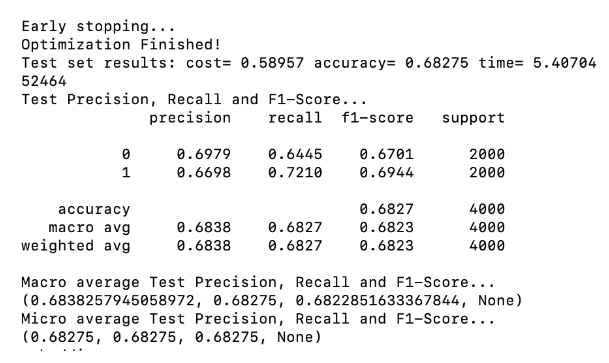